In [1]:
#1.Import Required Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os


In [2]:
#2.Extract Dataset
import zipfile

zip_path = "/content/plant_disease_split4.zip"
extract_path = "/mnt/data/plant_disease_data"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))


Extracted files: ['train', 'test']


In [3]:
#3.Define Paths
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")

print("Train classes:", os.listdir(train_dir))

Train classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Tomato_Early_blight', 'Pepper,_bell___Bacterial_spot']


In [4]:
#4.Data Augmentation & Loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2558 images belonging to 4 classes.
Found 639 images belonging to 4 classes.


In [5]:
#5.Load & Customize MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze early layers
for layer in base_model.layers[:-75]:
    layer.trainable = False
for layer in base_model.layers[-75:]:
    layer.trainable = True

In [6]:
#6.Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Adjust class count here
])


In [7]:
#7.Compile Model
optimizer = AdamW(learning_rate=1e-5, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
#8.Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 2,367,876 (9.03 MB)

 Non-trainable params: 219,072 (855.75 KB)

In [9]:
#9.Training with Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 773ms/step - accuracy: 0.2965 - loss: 1.7359 - val_accuracy: 0.5915 - val_loss: 1.0522 - learning_rate: 1.0000e-05
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 507ms/step - accuracy: 0.5634 - loss: 1.0286 - val_accuracy: 0.7653 - val_loss: 0.7435 - learning_rate: 1.0000e-05
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 501ms/step - accuracy: 0.7601 - loss: 0.6740 - val_accuracy: 0.8529 - val_loss: 0.5209 - learning_rate: 1.0000e-05
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 500ms/step - accuracy: 0.8438 - loss: 0.4623 - val_accuracy: 0.8732 - val_loss: 0.4117 - learning_rate: 1.0000e-05
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 540ms/step - accuracy: 0.8852 - loss: 0.3672 - val_accuracy: 0.9030 - val_loss: 0.3144 - learning_rate: 1.0000e-05
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 497ms/step - accuracy: 0.9128 - loss: 0.2958 - val_accuracy: 0.9296 - val_loss: 0.2563 - learning_rate: 1.0000e-05
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - acc

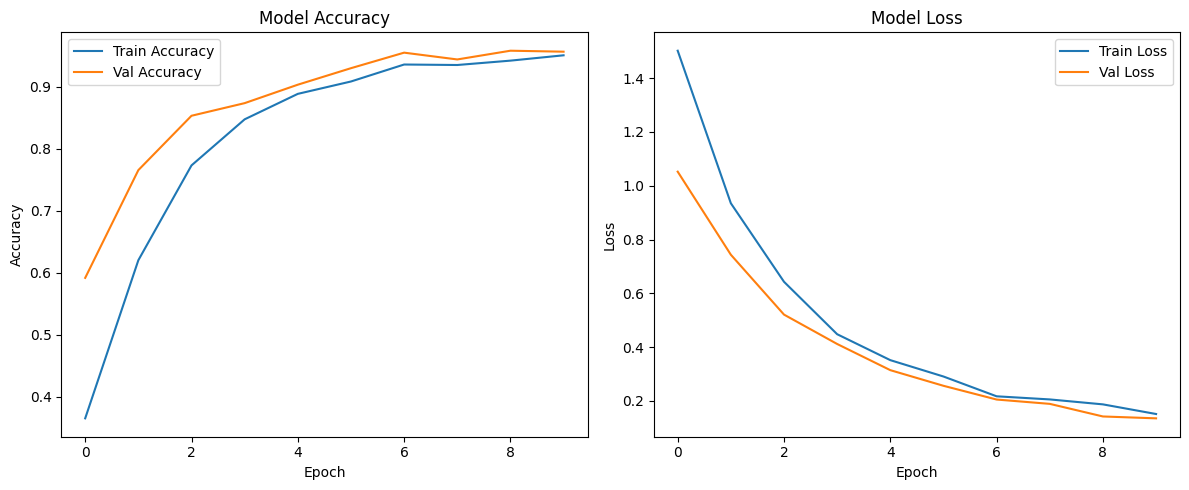

In [10]:
#10. Plot Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
#11.Evaluate on Validation Set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.9627 - loss: 0.1353
Validation Accuracy: 96.24%


In [12]:
#12.Evaluate on Test Set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 800 images belonging to 4 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9857 - loss: 0.0507
Test Accuracy: 97.00%


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step


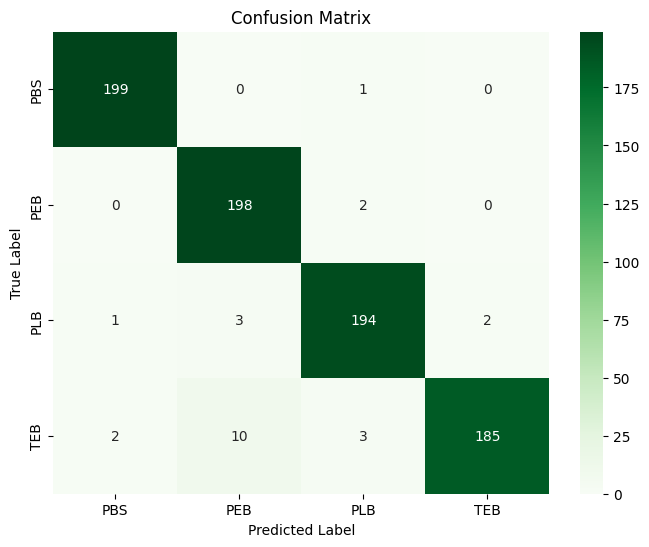

Classification Report:
               precision    recall  f1-score   support

         PBS       0.99      0.99      0.99       200
         PEB       0.94      0.99      0.96       200
         PLB       0.97      0.97      0.97       200
         TEB       0.99      0.93      0.96       200

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [13]:
#13.Confusion Matrix + Classification Report
predictions = np.argmax(model.predict(test_generator), axis=1)
true_labels = test_generator.classes

class_map = {
    "Pepper,_bell___Bacterial_spot": "PBS",
    "Potato___Late_blight": "PLB",
    "Potato___Early_blight": "PEB",
    "Tomato_Early_blight": "TEB"
}
original_class_labels = list(test_generator.class_indices.keys())
class_labels = [class_map[label] for label in original_class_labels]

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(true_labels, predictions, target_names=class_labels))

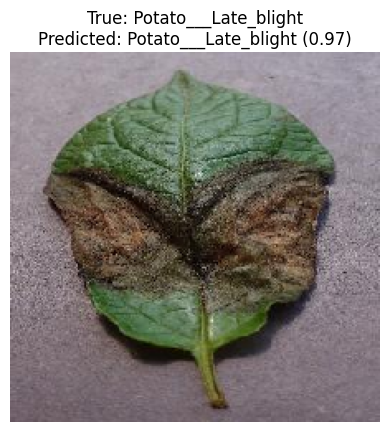

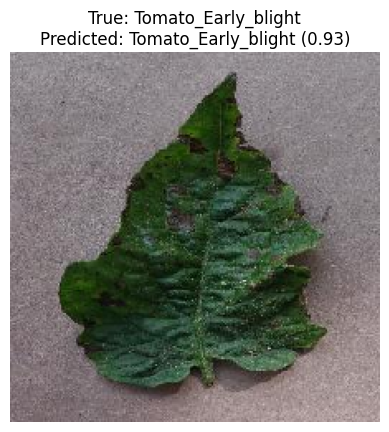

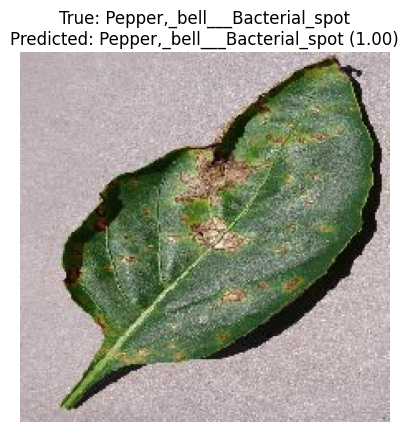

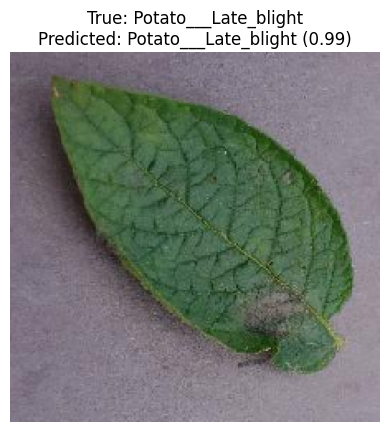

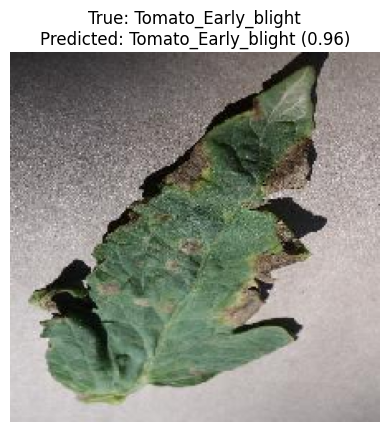

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Predict and display 5 random test samples
num_samples = 5

# Collect all images and labels from the test generator
# This might consume a lot of memory for large datasets
all_test_images = []
all_test_labels = []

# Reset the test generator to ensure we iterate from the beginning
test_generator.reset()

# Iterate through the generator to get all batches
# Use tqdm for a progress bar if the dataset is large
# from tqdm.notebook import tqdm
# for i in tqdm(range(len(test_generator)), desc="Collecting Test Data"):
for i in range(len(test_generator)):
    batch_images, batch_labels = next(test_generator)
    all_test_images.append(batch_images)
    all_test_labels.append(batch_labels)

# Concatenate batches into single numpy arrays
X_test = np.concatenate(all_test_images)
y_test = np.concatenate(all_test_labels)

# Get the class names from the generator
class_names = list(test_generator.class_indices.keys())

# Select random indices from the collected test set
indices = random.sample(range(len(X_test)), num_samples)

for i in indices:
    img = X_test[i]
    # Get the true label for the image
    true_label_index = np.argmax(y_test[i])
    true_label = class_names[true_label_index]

    # Predict for a single image
    # The model expects a batch, so we expand dimensions
    # Add verbose=0 to suppress prediction progress for each image
    pred_probs = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    pred_label_index = np.argmax(pred_probs)
    pred_label = class_names[pred_label_index]
    confidence = np.max(pred_probs)

    # Display the image and prediction
    # Assuming images were normalized to [0, 1] since rescale=1./255 was used
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {pred_label} ({confidence:.2f})")
    plt.axis('off')
    plt.show()